# Recommendation Engines

This carries on the work from "recommend.ipynb", which did some exploratory analysis, and tried to develop some computation methods based
on using dense matrices built via the pivot table function.  This work will try to work with sparse matrices, and write the functions that are required.  In particular, I intend to attempt both user-user and item-item collaborative filtering.

I would also like to attempt latent factor analysis.  The existing routines for matrix factorization reconstruct an entire matrix, rather than just a sub-portion.  I might try using stochastic gradient descent to carry out this factorization. 

In [1]:
#Libraries
#standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

%load_ext autoreload
%autoreload 2

%matplotlib inline

#save graphics as pdf too (for less revolting exported plots)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
%autosave 600 

Autosaving every 600 seconds


In [2]:
#read in the data.  (13MB or so)
#(N.B. I put Matt's header on it's own line, which is skipped, and added the UserID)
#initial playing data
#frequent users
#df=pd.read_csv('data/boardgame-frequent-users.csv',skiprows=1)

#full matrix (2E5 users, 400 games)
df=pd.read_csv('data/boardgame-users.csv',skiprows=1)
df.columns=('userID','gameID','rating')

detail_df=pd.read_csv('data/boardgame-details.csv',index_col=0)
name_dict=detail_df['title'].to_dict()

In [3]:
#find unique entries
users=df['userID'].unique()
games=df['gameID'].unique()

Nusers = len(users)
Ngames = len(games)
print('Nusers:{}, Ngames:{}'.format(Nusers,Ngames))

#sort the list.
users.sort()
games.sort()

#make a dict of user/games for correspondence between IDs and row/columns.
user_dict=dict(zip(users,np.arange(Nusers)))
game_dict=dict(zip(games,np.arange(Ngames)))

Nusers:193504, Ngames:402


In [4]:
#find changes in user IDs by looking at first difference.  (use fact that users are sorted together)
user_diff = np.diff(df['userID'])
diff_msk= (user_diff!=0)
#find entries where userID changes.  indices run from 0:len(df)-1 due to difference.
#Must add 1 to get correct index
diff_ind=np.arange(len(df)-1)[diff_msk]+1
#put in first index at zero, and last index at df
user_ind=np.insert(diff_ind,0,0,axis=0)
user_ind=np.append(user_ind,[len(df)],axis=0)
user_change=df['userID'][user_ind]
#now find single indices

In [5]:
#extract indices
score_row = np.array([user_dict[v] for v in df['userID'].values])
score_col = np.array([game_dict[v] for v in df['gameID'].values])
score_val = df['rating'].values

In [6]:
#subtract off mean user score from user score.

user_mean=np.zeros(Nusers)
score_val_u=np.zeros(score_val.shape)
single_users=[]
low_users=[]

#with the user indices, now takes linear time.  super fast.
for i in range(Nusers):
    sl = slice(user_ind[i],user_ind[i+1])
    mu=np.mean(score_val[sl])
    user_mean[i]=mu
    score_val_u[sl] = score_val[sl]-mu
    #grab single users.
    nreviews=user_ind[i+1]-user_ind[i]
    if (nreviews==1):
        single_users.append(i)
    if (nreviews<=5):
        low_users.append(i)
    if (i%10000==0):
        print('On user {} of {}'.format(i,Nusers))

#subtract off mean game score from user score.
game_mean=np.zeros(Ngames)
score_val_g=np.zeros(score_val.shape)
#do the simple way, since relatively only 400 games
for i in range(Ngames):
    msk= score_col==i
    mu=np.mean(score_val[msk])
    game_mean[i]=mu
    score_val_g[msk] = score_val[msk]-mu


On user 190000 of 193504


On user 170000 of 193504
On user 180000 of 193504


On user 160000 of 193504


On user 150000 of 193504


On user 130000 of 193504
On user 140000 of 193504


On user 120000 of 193504


On user 100000 of 193504
On user 110000 of 193504


On user 90000 of 193504



On user 80000 of 193504


On user 60000 of 193504
On user 70000 of 193504

On user 50000 of 193504


On user 30000 of 193504
On user 40000 of 193504


On user 20000 of 193504


On user 10000 of 193504


On user 0 of 193504


In [7]:
#Find number of "low users, and single review users"
print('Number of single users:{} Number of users with fewer than 5 reviews:{}'.format(len(single_users),len(low_users)))
#So around a quarter of the dataset has 5 or fewer reviews.

Number of single users:25191 Number of users with fewer than 5 reviews:61886


Now we can randomly split the dataset into testing/validation sets.  
Matt suggested taking care to ensure no reviewers were with left with no reviews.  
What if we ignore that? For the KNN approach, I was going to weight together the recommendations with the mean, so very little effect.  For the ALS-matrix factorization approach, these would have to get dropped anyway (as they are all None/NAN).  So yeah, it makes sense to filter those out.   This does mean that you can test your methods for new users, then again the recommendations were probably just median recommendations anyway.  For the moment, let's ignore that.  (And ultimately, I don't care about people with only a single review)

In [8]:
kf=KFold(n_splits=5,random_state=3413, shuffle=True)
split_ind=kf.split(np.arange(len(df)))
train_list=[]
test_list=[]
for train_ind,test_ind in split_ind:
    train_list.append(train_ind)
    test_list.append(test_ind)
    print(train_ind.shape,test_ind.shape)
    print(test_ind)

(4118900,) (1029724,)
[      3       4      19 ..., 5148615 5148619 5148620]


(4118899,) (1029725,)
[     10      13      14 ..., 5148609 5148611 5148621]
(4118899,) (1029725,)
[      0      11      15 ..., 5148614 5148616 5148622]


(4118899,) (1029725,)
[      2       7       8 ..., 5148608 5148617 5148623]
(4118899,) (1029725,)
[      1       5       6 ..., 5148599 5148604 5148618]


In [21]:
train_list[0]

array([      0,       1,       3, ..., 5148620, 5148621, 5148622])

In [9]:
#make a coordinate sparse matrix, then convert it to compressed row form.
def get_sparse_matrix(ind):
    score_coo = sparse.coo_matrix((score_val_g[ind],(score_row[ind],score_col[ind])))
    #convert to either compressed row or column matrix. (csr, csc)
    #use R fast row slicing, and fast arithmetic
    print(score_coo.shape)
    score_R = score_coo.tocsr()
    return score_R
score_train=get_sparse_matrix(train_list[0])
score_test = get_sparse_matrix(test_list[0])

(193504, 402)


(193503, 402)


# PCA

Let's try doing a PCA for dimensionality reduction.  Also do some clustering, and maybe even some filtering.  

In [102]:
%pdb OFF
svd=TruncatedSVD(n_components=20,random_state=439,n_iter=1000)
# %debug --breakpoint /home/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/truncated_svd.py:187

score_pca=svd.fit_transform(score_R)

KeyboardInterrupt: 

Automatic pdb calling has been turned OFF


In [21]:
comp=svd.components_
exp_var=svd.explained_variance_
#reconstruct the matrix by adding up components again.
score_recon=np.dot(score_pca,comp)
score_full=score_train.toarray()

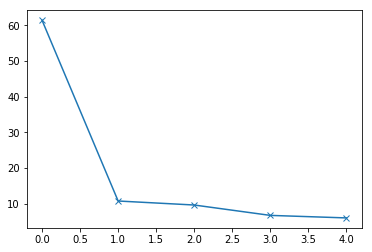

In [22]:
plt.plot(exp_var,'-x')
plt.show()

In [24]:
diff=score_recon-score_full
cost=np.sum(np.abs(diff)/(Nusers*Ngames))
print(cost)
print(diff[0:5,0:5])

0.592313877564
[[ 0.38650579  0.32182079  0.13009365  0.1543331  -0.10450587]
 [ 0.40596635  0.00233083 -0.20857872 -1.367775   -0.15081522]
 [-0.25777031 -0.19457546 -0.01022145 -0.60538809 -0.53606796]
 [-0.0104767   0.57551235 -0.04993931  0.08202462  0.03743651]
 [ 0.58054752  0.36785332  0.24405721  1.08269932 -0.16995015]]


In [109]:
#Plot the components against one another.
def plot_comp(score_pca):
    nc=score_pca.shape[1]
    print(nc)
    plt.figure(figsize=(10,10))
    for i in range(nc):
        for j in range(i,nc):
            plt.subplot(nc,nc,j+i*nc+1)
            #plt.scatter(score_pca[:,i],score_pca[:,j],marker='x')

    plt.show()            
    return
#will kill your computer 
#plot_comp(score_pca)
            

Evidently, there is not much to differentiate users based solely on their scores.  (Again, other people at the workshop commented on exactly this - they suggested there was more variation for a PCA based on games.)  Let us try the same PCA on the transposed matrix.  

Once again, this seems to have just found a big blob, which suggests that clustering is not meaningful.  (These are for the normalized scores where the average score for each game has been subtracted, before carrying out the PCA).  



# Item-Item filtering (via KNN)

A simple recommendation algorithm could be designed by using the reduced dimensions to carry out k-nearest neighbours.  It would be slow for large matrices.  Let's try this now for the reduced data set after the SVD. 

So I was initially writing my own code for this, but it seems that scikit-learn already has a nearest neighbour regressor (and nearest radius regressor) via sklearn.neighbours.RadiusNeighboursRegressor, and sklearn.neighbours.NearestNeighboursRegressor.  One concern is since I am using the scores (and want to predict the scores, do I need to feed it training data? Yes, I just gave it the scores to reproduce.  No problem.

Note that this is currently based on finding the nearest vectors via
$\text{min}_j|\vec{v}_i-\vec{v}_j|^2$, where we replace $\vec{v}$ with its k-nearest neighbors:
\begin{align}
    \bar{v}_i &= \sum_{i=1}^k c_{ij}v_j,\\
    \text{where } c_{ij} &= \frac{\vec{v}_i\cdot \vec{v}_j}{|\vec{v}|^2}
\end{equation}
Note that this unfortunately would underweight vectors which have the same scores as $v_i$, but have more information.
If I have $v = (1,nan,nan,-1,nan)$, that is closer to a vector like $v_{bad}=(-1,nan,nan,0,nan)$, than it is to a vector $v_{good}=(1,1,-2,-1,2)$.

In [139]:
tmin=score_train[0:2]

<2x402 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [205]:
Knn = 100
#So this currently gets all of the nearest neighbors.  That's daft.
#Make function to just get one at a time. 
# def get_knn_indices(score_mat,Knn,Nbatch=100):
#     """get_knn_indices
#     Extracts nearest k indices nearest vector for each row vector.
#     Inputs
#        score_mat: sparse matrix, where each row is a score vector. 
#                   (Best if CSR format)
#        Knn: number of nearest neighbours to keep
#     """
#     Nrows=score_mat.shape[0]
#     nvec = np.arange(Nrows).astype(int)
#     idx_array = np.zeros([Nrows,Knn])
#     #make an array of indices of nearest neighbours.
#     score_T = score_mat.transpose()

#     dnorm2=score_mat.multiply(score_mat).sum(axis=1)
#     for i in range(Nrows):
#         #calculate |v_i - v_j|^2 for all vectors.   
#         if (i%Nbatch==0):
#             #print('Iter {} of {}'.format(i,Nrows))
#             #compute batch of dot-products 
#             dot_batch = score_mat.dot(score_T[:,i:i+Nbatch]).tocsc()
#         dist2=dnorm2[i] - 2*dot_batch[:,i%Nbatch] + dnorm2
#         #ignore the values for any identical vectors 
#         dist2[abs(dist2)<=1E-12]=dist2.max()
#         dmat=np.array([dist2.T,nvec])
#         #the following sorts the array based on the values in the first row
#         idx = np.argsort(dmat[0])
#         #grab first Knn entries since sorted in ascending order, and want nearest.
#         idx_array[i,:]=idx[0,:Knn]
#     return idx_array

def get_cosine_distances(score_mat,ind,score_norm_inv):
    """calculate distances between vectors.
    Inputs:
    score_mat - CSR matrix of row vectors
    ind - specific index for vector v_i
    score_norm_inv - inverse euclidean norms for each vector.
    Return:
    dot_prods - vector of cosines between v_i, and all other vectors
    """
    #make an array of indices of nearest neighbours.
    score_vec = score_mat[ind].transpose()*score_norm_inv[ind]
    #note that this can be a bit inefficient (may be better to do as batch process with a number of columns.
    dot_prods=score_mat.dot(score_vec)
    dot_prods = np.multiply(dot_prods,score_norm_inv)
    return dot_prods

# def calc_norms(score_mat):
#     """calc_norms
#     Compute euclidean norm for each row in CSR matrix
#     """
#     dnorm=score_mat.multiply(score_mat).sum(axis=1)
#     dnorm=np.sqrt(dnorm)
#     return dnorm

def calc_inverse_norm(score_mat):
    """calc_inverse_norm
    Compute inverse of euclidean norm of reach row. i.e. (1/|R_i|) where
    R_i is the i_th row in the matrix.
    Treat 0 length vectors as having a small length (1E-10).
    """
    dnorm=score_mat.multiply(score_mat).sum(axis=1)
    inorm=1.0/np.maximum(np.sqrt(dnorm),1E-10)
    return inorm

def get_knn_indices(score_mat,Knn,score_norm_inv,ind):
    """get_knn_indices
    Extracts nearest k indices nearest vector for a particular row vector.
    Inputs
       score_mat: sparse matrix, where each row is a score vector. 
                  (Best if CSR format)
       Knn: number of nearest neighbours to keep
       inorm: list of inverse euclidean lengths of each vector. (1/|v|)
       ind: index of vector to find
    """

    dist2=get_cosine_distances(score_mat,ind,score_norm_inv)
    #the following sorts the array based on the values in the first row
    #then grab first Knn entries since sorted in ascending order, and want nearest.
    Nrows=score_mat.shape[0]
    nvec = np.arange(Nrows).astype(int)
    dmat=np.array([dist2.T,nvec])
    idx = np.argsort(dmat[0])
    idx_vec=idx[0,:Knn]

    return idx_vec


def get_rad_indices(score_mat,score_norm_inv,rad,ind):
    """get_knn_index
    Extracts nearest k indices nearest vector for a particular row vector.
    Inputs:
       score_mat: sparse matrix, where each row is a score vector. 
                  (Best if CSR format)
       rad: radius of ball to keep
       norm_inv: list of euclidean lengths of each vector.
       ind: index of vector to find
    """
    dist2=get_cosine_distances(score_mat,ind,score_norm_inv)    
    nvec = np.arange(score_mat.shape[0]).astype(int)    
    #the following sorts the array based on the values in the first row
    idx_vec = nvec[dist2>rad*rad]
    return idx_vec

#this is super slow.  (a full KNN search takes a long time basically.  Not needed - just do in time/as required?)
%pdb off
Knn = 100
#k_ind=get_k_indices(score_train[0:10000], Knn,Nbatch=100)
r_ind = get_rad_indices(score_train,inorm,rad=0.5,ind=100)

IndexError: too many indices for array

Automatic pdb calling has been turned OFF


In [213]:
np.array((dvec>0.5)).squeeze()


array([ True, False, False, ..., False, False, False], dtype=bool)

In [156]:
dnorm=calc_norms(score_train)
inorm=calc_inverse_norm(score_train)

In [193]:
inorm[100]

matrix([[ 5.96740119]])

In [ ]:
dvec=get_cosine_distances(score_train,0,inorm)
np.sum(dvec>0.5)

In [186]:
#compute average vector up vectors.
def kvec(score_mat,idx_array,ind):
    """kvec 
    Given the nearest indices, actually go and calculate the 
    averaged knn vector.  Note this would be dense, so only do this on demand. 
    """
    Ncol=score_mat.shape[1]
    #vector we want to reconstruct via nearby vectors.
    ai = score_mat[ind]
    kvec=np.zeros((1,Ncol))
    for idx in idx_array[ind]:
        vj = score_mat[idx]
        v_norm=np.dot(vj,vj.T)
        kvec += np.dot(ai,vj.T)/v_norm*(vj)
    return kvec

In [87]:
kvec(score_train,k_ind,900)    

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.59723861e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -1.37953885e-03,   0.00000000e+00,   0.00000000e+00,
         -6.97038128e-01,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.49184799e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,  -6.82043752e-02,
          0.00000000e+00,   0.00000000e+00,   3.49024392e-01,   0.00000000e+00,
          0.00000000e+00,  -7.62263377e-01,   0.00000000e+00,   0.00000000e+00,
          2.04205928e+00,   0.00000000e+00,   0.00000000e+00,   8.38611642e-01,
          0.00000000e+00,   2.86335005e-02,   0.00000000e+00,   1.20597684e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   1.61010230e-01,
          0.00000000e+00,   0.00000000e+

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -5.21994186e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.39041917e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   6.33030662e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.60918618e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+

In [47]:
print(kmat[0:5])
print(score_pca[0:5])

[[-24.81124227 -12.20737558  -6.01236285  -4.22961506   8.19159786]
 [  2.84880633  -8.97626212  -3.77494725 -20.55481635  -0.65267763]
 [ 18.49725774  -0.49910491  12.10706609  13.59896053  19.69734593]
 [ -5.16672454  -0.62825222   0.28918555  -7.49676265  -7.0854568 ]
 [-19.10398172  -4.82197861   0.76085909   0.81799849   7.71298224]]
[[-5.71060411 -2.48102002 -0.15599939 -0.75286063 -0.04790094]
 [ 1.08208226 -2.21546958 -0.53473732 -3.72010125 -1.94760456]
 [ 4.92739943 -0.90350248  1.56479807  2.69635511  2.31691077]
 [-2.82628778 -0.70687679  0.63864529 -1.17124864 -3.93932912]
 [-5.26869138 -0.73611451  1.20592093  0.28120331  0.56647573]]


In [60]:
plt.hist(k_ind)
plt.show()

In [19]:
idx_array.shape

(2473, 5)

In [103]:
dnorm

array([[  39.35988911,    2.29470957,  -28.28188908, ...,   21.58662739,
          72.54089086,    4.09421793],
       [   2.29470957,   23.99746831,   -8.0463622 , ...,    8.82009926,
          -1.69167873,    5.00156789],
       [ -28.28188908,   -8.0463622 ,   40.18258126, ...,  -20.71462527,
         -55.98606086,    4.13452836],
       ..., 
       [  21.58662739,    8.82009926,  -20.71462527, ...,   38.87677693,
          10.01308011,   29.60866848],
       [  72.54089086,   -1.69167873,  -55.98606086, ...,   10.01308011,
         171.67284391,  -27.68291711],
       [   4.09421793,    5.00156789,    4.13452836, ...,   29.60866848,
         -27.68291711,   40.57915161]])

In [35]:
#So let's just try the sklearn version (which has probably been run through Cython)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [88]:
#Kneighbors does not remove duplicates.
Kneigh=KNeighborsRegressor(n_neighbors=10,n_jobs=3)
#Radneigh
Radneigh=RadiusNeighborsRegressor(n_neighbors=10,n_jobs=3)
Kneigh.fit(score_train,score_train)
Radneigh.fit(score_train,score_train)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, p=2, radius=1.0, weights='uniform')

In [137]:
%pdb off
[neigh2_dist,neigh2_ind]=Radneigh.radius_neighbors(score_train[50000])
plt.hist(neigh2_dist[0],bins=20)
plt.show()

Automatic pdb calling has been turned OFF


In [127]:
[neigh1_dist,neigh1_ind]=Kneigh.kneighbors(score_train[100])


In [ ]:
#so prediction does not really work out of the box.
#Attempts to reshape are not working, since indexing is returning (1,N) array, not (N,) array.
#Might be issue for sparse?
%pdb off 
[neigh1_pred]=Kneigh.predict(score_train[100,:])
[neigh2_pred]=Radneigh.predict(score_train[100,:])

In [126]:
k_ind[100]

array([ 9872.,   626.,  2398.,  2127.,   216.,  6436.,  5515.,  4530.,  7824.,
        6017.,  9914.,   209.,   208.,  1101.,  8995.,  2825.,  8544.,  8339.,
        7823.,  8036.,  5471.,  2144.,  5475.,  9223.,  5481.,  9427.,  1630.,
        6981.,  9673.,   809.,  8539.,  8541.,  5050.,  9903.,  3712.,  4333.,
        7983.,   608.,   447.,  7207.,  7556.,  4961.,  1790.,  4438.,  2838.,
        1640.,  5625.,  9781.,  7867.,  6583.,  7152.,  9779.,  6512.,  4344.,
         174.,  2098.,  1761.,  2580.,  1335.,   843.,  5556.,  8175.,  9069.,
         866.,  9070.,  6430.,  4618.,  9924.,  9926.,  6356.,  9072.,  6355.,
        1868.,   671.,  5573.,  9500.,  7323.,  8524.,  7996.,  1912.,  6084.,
        2778.,  5187.,  9847.,  9165.,   620.,  5303.,  5305.,  5183.,  4712.,
         621.,  9884.,  6086.,  3609.,  9699.,  5202.,  3603.,  3529.,  9463.,
        4276.])

In [ ]:
#Look into joblib.parallel for some embarassingly parallel computations
#(i.e. takes care of threading for me)
#Particularly useful for data parallel operations.        

# Latent Factor Analysis

Here we will try to factor the scoring matrix $S=WH$, subject to the cost function:
\begin{align}
J &= \sum_{i,j \in S_{ij}\ne 0} \left(S_{ij} - \sum_{k=1}^{N_f}W_{ik}H_{kj}\right)^2
&+\lambda^{(1)} \sum_{i,j} |W_{ij}|+\lambda^{(1)} \sum_{i,j} |H_{ij}|\nonumber\\
  &+\lambda^{(2)} \sum_{i,j} |W_{ij}|^2+\lambda^{(2)} \sum_{i,j} |H_{ij}|^2\nonumber.
  \end{align}
Similar to other problems, the $\lambda^{(1)}$ regularization enforces sparsity on the problem.  Could we also put in some sort of AIC correction based on the number of degrees of freedom? Something like $N_f^2$?
  
We can then test the method on how well it recreates existing scores,
and make predictions based on the scores for games the user has not rated.  

\begin{align}
    \frac{\partial_{J}}{\partial W_{nm}} & = \sum_{ij\ne 0} \delta_{in}H_{mj}(S_{ij} -\sum_{k=1}^{N_f}W_{im}H_{mj})
    +\lambda^{(1)}+\lambda^{(2)}W_{nm}
\end{align}


In [ ]:
#Do Stochastic Gradient Descent on
W = np.zeros((Nusers,Nf))
H = np.zeros((Nf,Ngames))

def cost(R,W,H,l1,l2,lN):
    """cost(R,W,H)
    Return cost function
    """
    
    J = 0
    nrows,ncols=R.shape
    for i in range(nrows):
        for j in range(ncols):
            J+= (R[i,j]- np.dot(W[i,:],H[:,j]))**2 
            
    J+= l1*np.sum(W) +l1*np.sum(H) + l2*np.sum(W*W)+l2*np.sum(H*H) + lN*Nf*Nf
    return J 

def gradW(R,W,H,l1,l2,lN):
    """gradW
    Calculate derivatives of cost w.r.t. W 
    """
    gW = 
    gW = l1*(W>0) + l2*W
    return gW

In [19]:
r = np.random.random((3,3))
np.sum(r)

4.740640165451727